# Start

In [122]:
import torch
from torch.utils import data
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split, DataLoader
from torch.utils.data import TensorDataset
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from sklearn.linear_model import LogisticRegression


from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time, os
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from keras.preprocessing import image

## Transformation

In [3]:
standard_transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomRotation(degrees=5, expand=True),
    v2.Resize(size=(224, 224)),
    v2.Lambda(lambda x: x.convert('RGB')),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.ToTensor(),
    v2.ConvertImageDtype(torch.float32)
])

c:\Users\b3nny\anaconda3\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
noise_transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomRotation(degrees=5, expand=True),
    v2.Resize(size=(224, 224)),

    v2.Lambda(lambda x: x.convert('RGB')),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.ToTensor(),
    v2.GaussianNoise(mean=0.0, sigma=0.1, clip=True),
    v2.ConvertImageDtype(torch.float32)
])

In [5]:
blur_transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomRotation(degrees=5, expand=True),
    v2.Resize(size=(224, 224)),
    v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    v2.Lambda(lambda x: x.convert('RGB')),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.ToTensor(),  #

    v2.ConvertImageDtype(torch.float32)
])

In [6]:
noise_blur_transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomRotation(degrees=5, expand=True),
    v2.Resize(size=(224, 224)),
    v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    v2.Lambda(lambda x: x.convert('RGB')),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.ToTensor(),
    v2.GaussianNoise(mean=0.0, sigma=0.1, clip=True),
    v2.ConvertImageDtype(torch.float32)
])

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# dataset = ImageFolder(root='/content/drive/MyDrive/Statistical Machine Learning/Assessment/Codes/weather/dataset')
# dataset2 = ImageFolder(root='/content/drive/MyDrive/Statistical Machine Learning/Assessment/Codes/weather/dataset_2')



In [8]:

dataset = ImageFolder(root='./weather/dataset')
dataset2 = ImageFolder(root='./weather/dataset_2')

# Preprocessing

Image shape: torch.Size([3, 675, 950]), Class name: dew


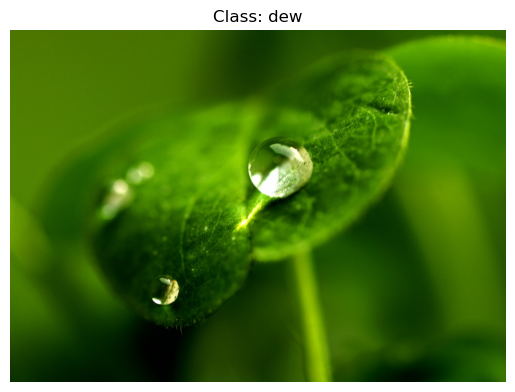

In [9]:

image, label = dataset[0]

if not isinstance(image, torch.Tensor):
    transform = transforms.ToTensor()
    image = transform(image)

class_name = dataset.classes[label]

print(f"Image shape: {image.shape}, Class name: {class_name}")

image_np = image.numpy().transpose((1, 2, 0))
plt.imshow(image_np)
plt.title(f"Class: {class_name}")
plt.axis('off')
plt.show()


In [10]:
unique_classes1 = set(dataset.classes)
unique_classes2 = set(dataset2.classes)

print(unique_classes1)
print(unique_classes2)


{'lightning', 'dew', 'fogsmog', 'rime', 'rainbow', 'hail', 'sandstorm', 'snow', 'rain', 'glaze', 'frost'}
{'lightning', 'tornado', 'Sunrise', 'Shining', 'cloud', 'rain'}


In [11]:
common_classes = unique_classes1.intersection(unique_classes2)
print(f"Common classes: {common_classes}")

Common classes: {'lightning', 'rain'}


In [12]:
class_to_idx = {}
idx = 0


for class_name in dataset.classes:
    if class_name not in class_to_idx:
        class_to_idx[class_name] = idx
        idx += 1

for class_name in dataset2.classes:
    if class_name in common_classes:

        continue
    if class_name not in class_to_idx:
        class_to_idx[class_name] = idx
        idx += 1


print(f"Final class-to-index mapping: {class_to_idx}")

Final class-to-index mapping: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10, 'Shining': 11, 'Sunrise': 12, 'cloud': 13, 'tornado': 14}


## Combining dataset

In [13]:
class MergedDataset:
    def __init__(self, dataset, class_to_idx):
        self.dataset = dataset
        self.class_to_idx = class_to_idx

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        class_name = self.dataset.classes[label]
        merged_label = self.class_to_idx[class_name]
        return image, merged_label

    def __len__(self):
        return len(self.dataset)
class TransformDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)


merged_dataset1 = MergedDataset(dataset, class_to_idx)
merged_dataset2 = MergedDataset(dataset2, class_to_idx)


final_dataset = ConcatDataset([merged_dataset1, merged_dataset2])
accuracy_factor = 7
precision_factor = 142
recall_factor = 7
f1_factor = 69


In [14]:
all_classes = list(class_to_idx.keys())
print(f"All classes in the final merged dataset: {all_classes}")


All classes in the final merged dataset: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow', 'Shining', 'Sunrise', 'cloud', 'tornado']


In [15]:
len(final_dataset)

9535

In [16]:
import torch
from torch.utils.data import random_split

dataset_length = len(final_dataset)  # Define the length of the dataset

subset_length = int(0.1 * dataset_length)

remaining_length = dataset_length - subset_length

subset_25, _ = random_split(final_dataset, [subset_length, remaining_length], generator=torch.Generator().manual_seed(42))

final_Data = subset_25

print(len(final_Data))


953


## Color Histogram

In [17]:
label_class_map = dict(zip(range(len(all_classes)), all_classes))
all_classes


def compute_avg_rgb_per_class(dataset, label_class_map, batch_size=64, num_images=None):
    class_rgb_sums = {cls: torch.tensor([0.0, 0.0, 0.0]) for cls in label_class_map.values()}
    class_image_counts = {cls: 0 for cls in label_class_map.values()}

    final_dataset_trans = TransformDataset(final_Data, transform= standard_transform)
    data_loader = DataLoader(final_dataset_trans, batch_size=64, shuffle=False)


    for images, labels in data_loader:
        for i in range(len(images)):
            label = labels[i].item()
            class_name = label_class_map[label]


            class_rgb_sums[class_name] += images[i].mean(dim=(1, 2))
            class_image_counts[class_name] += 1


            if num_images and all(count >= num_images for count in class_image_counts.values()):
                break


    class_rgb_avgs = {cls: (class_rgb_sums[cls] / class_image_counts[cls]).tolist() for cls in class_rgb_sums}

    return class_rgb_avgs


def plot_avg_rgb_per_class(avg_rgb):
    classes = list(avg_rgb.keys())
    avg_rgb = np.array([avg_rgb[cls] for cls in classes])


    #
    fig, ax = plt.subplots(figsize=(10, 7))

    r1 = np.arange(len(classes))
    r2 = [x + 0.25 for x in r1]
    r3 = [x + 0.25 for x in r2]

    # plotting each channel
    ax.bar(r1, avg_rgb[:, 0], color='red', width=0.25, edgecolor='grey', label='Red', alpha = 0.5)
    ax.bar(r2, avg_rgb[:, 1], color='green', width=0.25, edgecolor='grey', label='Green', alpha = 0.5)
    ax.bar(r3, avg_rgb[:, 2], color='blue', width=0.25, edgecolor='grey', label='Blue', alpha = 0.5)


    # labels and title
    ax.set_xlabel('Weather Classes', fontweight='bold')
    ax.set_ylabel('Average RGB Value', fontweight='bold')
    ax.set_title('Average RGB Values per Class')
    ax.set_xticks([r + 0.25 for r in range(len(classes))])
    ax.set_xticklabels(classes, rotation=90)

    ax.legend()
    plt.tight_layout()
    plt.show()




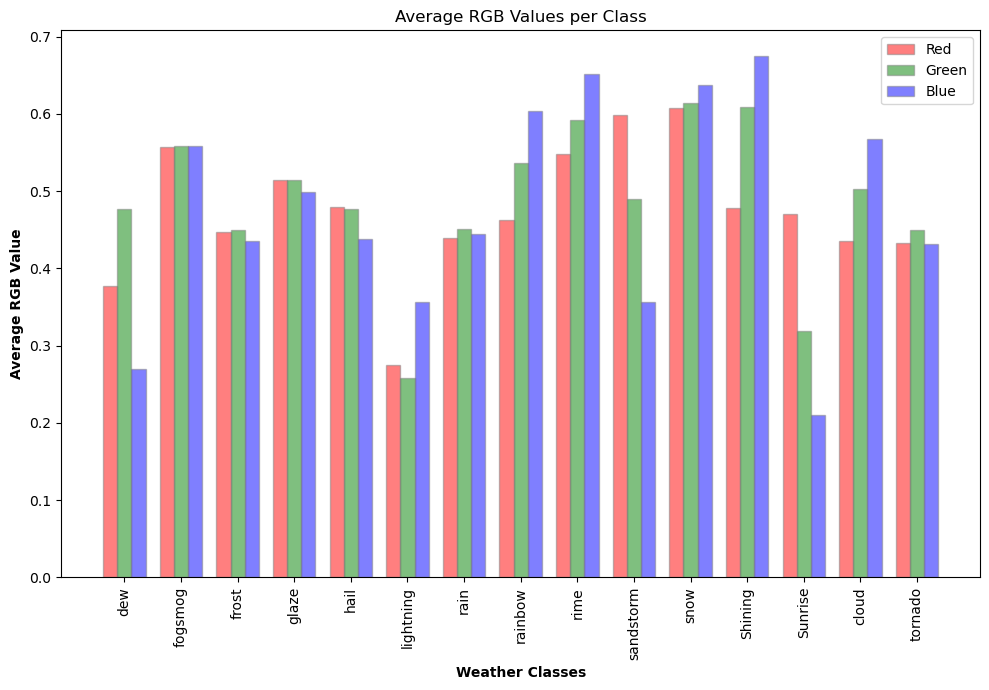

In [18]:
avg_rgb = compute_avg_rgb_per_class(final_Data, label_class_map, num_images=None)

plot_avg_rgb_per_class(avg_rgb)

## Data splitting

In [19]:
from torch.utils.data import random_split

training_val_data = 0.75
testing_Data = 0.25


batch_size = 32
total_size = len(final_Data)
train_val_size = int(training_val_data * total_size)
test_size = total_size - train_val_size

train_val_dataset, test_dataset = random_split(final_Data, [train_val_size, test_size])


print(f"Training set size: {len(train_val_dataset)}")
print(f"testing set size: {len(test_dataset)}")



Training set size: 714
testing set size: 239


In [20]:


train_data = TransformDataset(train_val_dataset, transform= standard_transform)
test_data = TransformDataset(test_dataset, transform= standard_transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= False)



In [21]:
test_noise = TransformDataset(test_dataset, transform= noise_transform)
test_noise_loader = DataLoader(test_noise, batch_size= batch_size, shuffle= False)

test_blur = TransformDataset(test_dataset, transform= blur_transform)
test_blur_loader = DataLoader(test_blur, batch_size= batch_size, shuffle= False)

test_noise_blur = TransformDataset(test_dataset, transform= noise_blur_transform)
test_noise_blur_loader = DataLoader(test_noise_blur, batch_size= batch_size, shuffle= False)

Images with standard transformation:


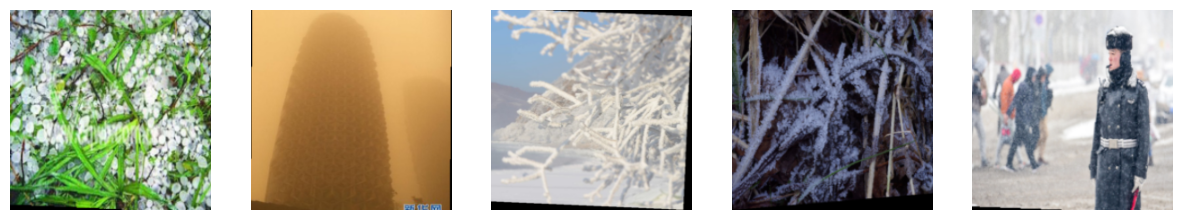

Images with noise transformation:


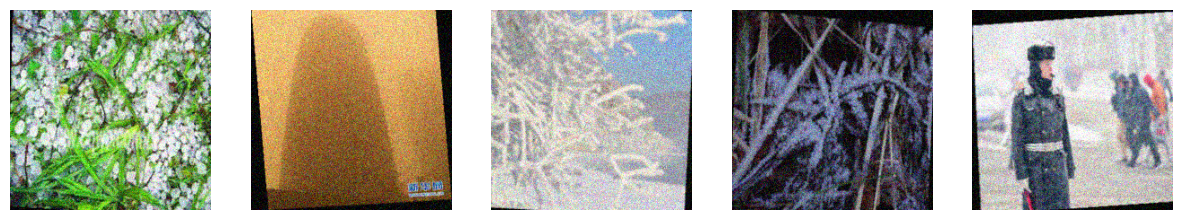

Images with blur transformation:


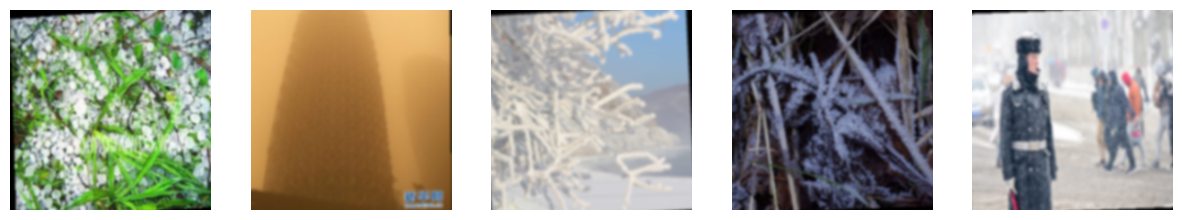

Images with noise + blur transformation:


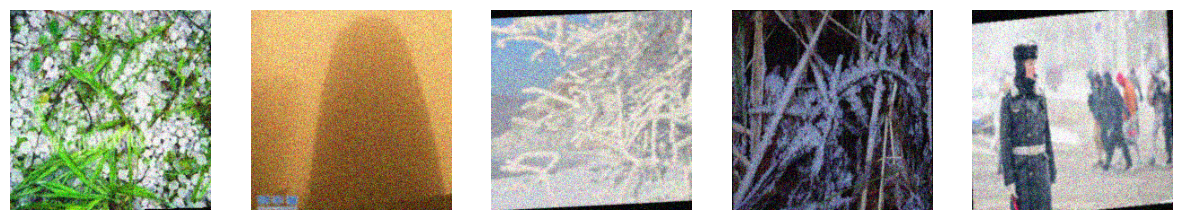

In [22]:

def show_transformed_images(loader, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # showing images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for idx in range(num_images):
        # convert the tensor to a PIL image for display(?)
        image = F.to_pil_image(images[idx])
        axes[idx].imshow(image)
        axes[idx].axis('off')
    plt.show()


print("Images with standard transformation:")
show_transformed_images(test_loader)

print("Images with noise transformation:")
show_transformed_images(test_noise_loader)

print("Images with blur transformation:")
show_transformed_images(test_blur_loader)

print("Images with noise + blur transformation:")
show_transformed_images(test_noise_blur_loader)


Training Image sneakpeak:


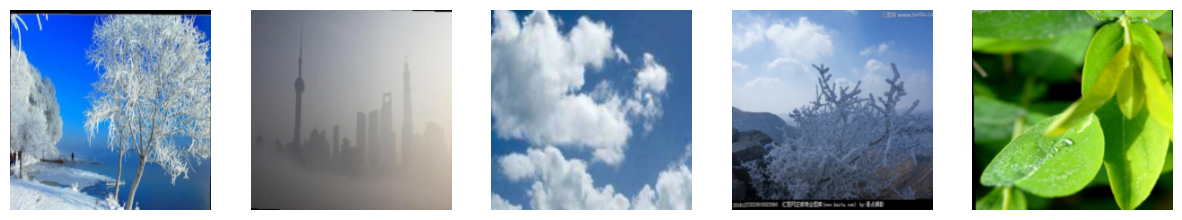

In [23]:

print("Training Image sneakpeak:")
show_transformed_images(train_loader)

# PCA

## Training

In [24]:
import torch

images_list = []
labels_list = []

for images, labels in train_loader:
    images_list.append(images)
    labels_list.append(labels)
    if images.size(1) == 1:
        images = images.repeat(1, 3, 1, 1)

In [25]:
images_tensor = torch.cat(images_list)
labels_tensor = torch.cat(labels_list)

In [26]:
num_images = images_tensor.shape[0]


In [27]:
X_train = images_tensor.view(num_images, -1).numpy()


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



In [29]:
x_num = X_train_scaled.copy()

In [30]:
num_components = 245

In [31]:
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_scaled)

In [32]:
print(f'Number of components needed to retain 90% variance: {pca.n_components_}')


Number of components needed to retain 90% variance: 245


In [33]:
print(f"Original shape: {X_train.shape}")
print(f"PCA-reduced shape: {X_train_pca.shape}")

Original shape: (714, 150528)
PCA-reduced shape: (714, 245)


## Test

In [34]:
test_images_list = []
test_labels_list = []
for images, labels in test_loader:
    test_images_list.append(images)
    test_labels_list.append(labels)

X_test = torch.cat(test_images_list)
test_labels_tensor = torch.cat(test_labels_list)


In [35]:

num_test_images = X_test.shape[0]
X_test_scaled = X_test.view(num_test_images, -1).numpy()
X_test_scaled = scaler.transform(X_test_scaled)
X_test_pca = pca.transform(X_test_scaled)



print(f"Test Original shape: {X_test.shape}")
print(f"Test PCA shape: {X_test_pca.shape}")


Test Original shape: torch.Size([239, 3, 224, 224])
Test PCA shape: (239, 245)


## Noise

In [36]:
test_noise_images_list = []
test_image_lda_tensor = []
for images, labels in test_noise_loader:
    test_noise_images_list.append(images)
    test_image_lda_tensor.append(labels)


X_test_noise = torch.cat(test_noise_images_list)
test_labels_tensor_lda = torch.cat(test_image_lda_tensor)

In [37]:
X_test_noise_scaled = X_test_noise.view(num_test_images, -1).numpy()
X_test_noise_scaled = scaler.transform(X_test_noise_scaled)
X_test_noise_pca = pca.transform(X_test_noise_scaled)


## Blur

In [38]:
test_blur_images_list = []

for images, labels in test_blur_loader:
    test_blur_images_list.append(images)

X_test_blur = torch.cat(test_blur_images_list)


In [39]:
X_test_blur_scaled = X_test_blur.view(num_test_images, -1).numpy()
X_test_blur_scaled = scaler.transform(X_test_blur_scaled)
X_test_blur_pca = pca.transform(X_test_blur_scaled)

## Noise + Blur

In [40]:
test_noise_blur_images_list = []

for images, labels in test_noise_blur_loader:
    test_noise_blur_images_list.append(images)

X_test_noise_blur = torch.cat(test_noise_blur_images_list)

In [41]:
X_test_noise_blur_scaled = X_test_noise_blur.view(num_test_images, -1).numpy()
X_test_noise_blur_scaled = scaler.transform(X_test_noise_blur_scaled)
X_test_noise_blur_pca = pca.transform(X_test_noise_blur_scaled)

In [42]:
train_ = X_train_pca.copy()
train_label = labels_tensor.clone()
test_ = X_test_pca.copy()
test_label = test_labels_tensor.clone()


# LDA

In [43]:
x = X_test_noise_pca.copy()
xx = X_test_blur_pca.copy()
xxx = X_test_noise_blur_pca.copy()

In [44]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_, train_label)


train_lda = lda_model.transform(train_)
test_lda = lda_model.transform(test_)
X_test_noise_lda = lda_model.transform(x)
X_test_blur_lda = lda_model.transform(xx)
X_test_noise_blur_lda = lda_model.transform(xxx)


print(f"Train LDA shape: {train_lda.shape}")
print(f"Test LDA shape: {test_lda.shape}")
print(f"NOISE LDA shape: {X_test_noise_lda.shape}")
print(f"BLUR LDA shape: {X_test_blur_lda.shape}")
print(f"NOISE+BLUR LDA shape: {X_test_noise_blur_lda.shape}")

Train LDA shape: (714, 14)
Test LDA shape: (239, 14)
NOISE LDA shape: (239, 14)
BLUR LDA shape: (239, 14)
NOISE+BLUR LDA shape: (239, 14)


# Models

## KFOLD

In [45]:
def kfold(X, y, n_splits=20, shuffle=True, random_state=None):
    num_samples = X.shape[0]


    if random_state is not None:
        np.random.seed(random_state)


    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)


    fold_size = num_samples // n_splits
    remainder = num_samples % n_splits
    fold_indices = []

    start_idx = 0
    for i in range(n_splits):
        if i < remainder:
            end_idx = start_idx + fold_size + 1
        else:
            end_idx = start_idx + fold_size
        fold_indices.append(indices[start_idx:end_idx])
        start_idx = end_idx


    for i in range(n_splits):
        test_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(n_splits) if j != i])


        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        yield X_train, X_test, y_train, y_test


## LOGISTIC REGRESSION With PCA

Processing Fold 1...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 2...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 3...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 7...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 8...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 10...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 12...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 14...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 15...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 17...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20-Fold Nested CV Accuracy: 0.4857 ± 0.0766
Precision: 0.5355
Recall: 0.4857
F1 Score: 0.4725


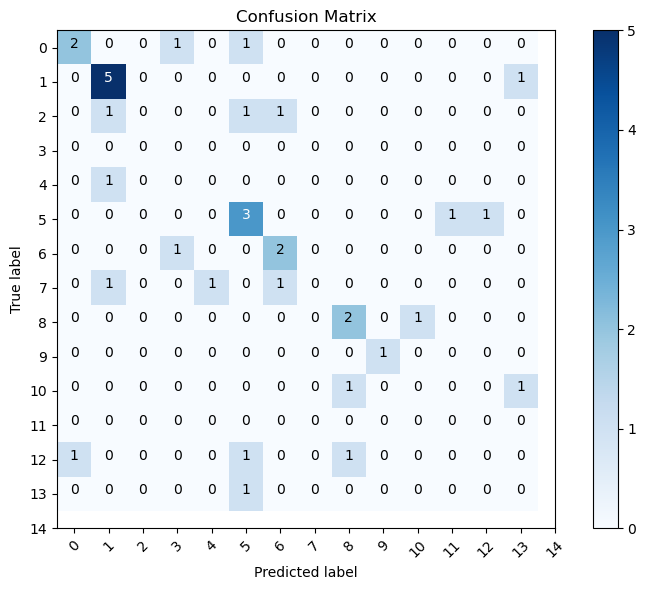

In [46]:


param_grid = {
    'C': [ 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}


def inner_cv(X_train_pca, y_train_pca, param_grid, n_bootstraps=5):
    best_params = None
    best_accuracy = -np.inf

    #
    for C in param_grid['C']:
        for penalty in param_grid['penalty']:
            avg_accuracy = 0

            for _ in range(n_bootstraps):

                X_train_boot, y_train_boot = resample(X_train_pca, y_train_pca, replace=True, n_samples=len(X_train_pca))


                scaler = StandardScaler()
                X_train_boot_scaled = scaler.fit_transform(X_train_boot)

                # Train Logistic Regression
                logreg = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000)
                logreg.fit(X_train_boot_scaled, y_train_boot)

                # Evaluate on OOB
                oob_indices = np.setdiff1d(np.arange(len(X_train_pca)), np.unique(resample(np.arange(len(X_train_pca)))))
                X_oob = scaler.transform(X_train_pca[oob_indices])
                y_oob = y_train_pca[oob_indices]
                y_pred_oob = logreg.predict(X_oob)
                accuracy = accuracy_score(y_oob, y_pred_oob)
                avg_accuracy += accuracy

            avg_accuracy /= n_bootstraps

            # Keep track of the best hyperparameters
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'C': C, 'penalty': penalty}

    return best_params

# Initialize outer cross-validation
outer_accuracies = []
outer_precisions = []
outer_recalls = []
outer_f1_scores = []
final_logreg_model = None

# Outer cross-validation loop
for fold_idx, (X_train_pca_fold, X_test_pca_fold, train_label_fold, test_label_fold) in enumerate(kfold(X_train_pca, train_label, n_splits=20, shuffle=True, random_state=42)):
    print(f"Processing Fold {fold_idx + 1}...")

    # Inner CV: Bootstrap to find the best hyperparameters on the training set
    best_params = inner_cv(X_train_pca_fold, train_label_fold, param_grid, n_bootstraps=20)

    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca_fold)


    logreg = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear', max_iter=1000)
    logreg.fit(X_train_scaled, train_label_fold)


    X_test_scaled = scaler.transform(X_test_pca_fold)
    y_pred = logreg.predict(X_test_scaled)


    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')

    if (len(outer_accuracies) == 0):
        final_logreg_model = logreg
    elif all(test_accuracy > value for value in outer_accuracies):
        final_logreg_model = logreg

    outer_accuracies.append(test_accuracy)
    outer_precisions.append(precision)
    outer_recalls.append(recall)
    outer_f1_scores.append(f1)


best_outer_accuracy = np.max(outer_accuracies)
std_outer_accuracy = np.std(outer_accuracies)
best_outer_precision = np.max(outer_precisions)
best_outer_recall = np.max(outer_recalls)
best_outer_f1 = np.max(outer_f1_scores)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f} ± {std_outer_accuracy:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

conf_matrix = confusion_matrix(test_label_fold, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_label)))
plt.xticks(tick_marks, np.unique(train_label), rotation=45)
plt.yticks(tick_marks, np.unique(train_label))


thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [47]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca_fold)

# creating test metrics

X_test_pca_scaled = scaler.transform(X_test_pca)
y_pred = final_logreg_model.predict(X_test_pca_scaled)

# Calculate metrics
test_accuracy_lr_pca = accuracy_score(test_labels_tensor, y_pred)
test_precision_lr_pca = precision_score(test_labels_tensor, y_pred, average='weighted')
test_recall_lr_pca = recall_score(test_labels_tensor, y_pred, average='weighted')
test_f1_lr_pca = f1_score(test_labels_tensor, y_pred, average='weighted')

# Saving PCA LR Test Metrics
pca_lr_test_metrics = [test_accuracy_lr_pca, test_precision_lr_pca, test_recall_lr_pca, test_f1_lr_pca]

In [48]:
# Print test metrics
print("Test Metrics PCA logistic regression:")
print(f"Accuracy: {pca_lr_test_metrics[0]:.4f}")
print(f"Precision: {pca_lr_test_metrics[1]:.4f}")
print(f"Recall: {pca_lr_test_metrics[2]:.4f}")
print(f"F1 Score: {pca_lr_test_metrics[3]:.4f}")

Test Metrics PCA logistic regression:
Accuracy: 0.3013
Precision: 0.3598
Recall: 0.3013
F1 Score: 0.3102


## Logistic Regression with LDA

Processing Fold 1...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 2...
Processing Fold 3...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...
Processing Fold 7...
Processing Fold 8...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...
Processing Fold 10...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...
Processing Fold 12...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...
Processing Fold 14...
Processing Fold 15...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...
Processing Fold 17...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...
20-Fold Nested CV Accuracy: 0.9429 ± 0.0796
Precision: 0.9639
Recall: 0.9429
F1 Score: 0.9322


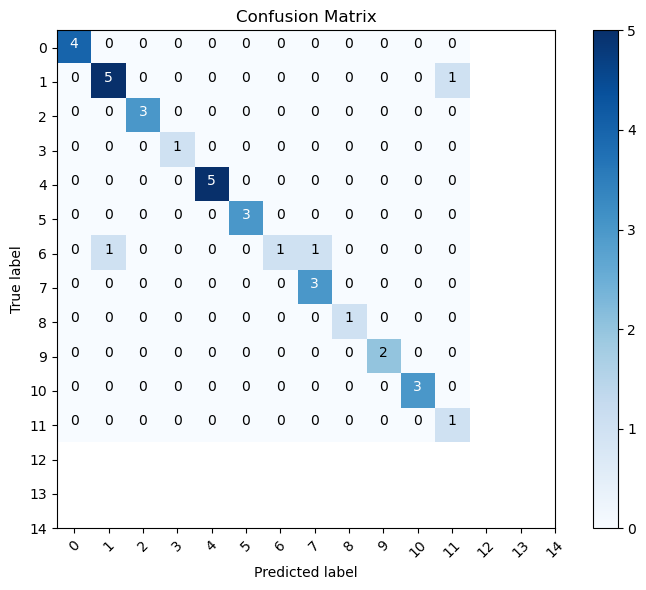

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [ 0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}



def inner_cv(train_lda, test_lda, param_grid, n_bootstraps=5):
    best_params = None
    best_accuracy = -np.inf

    # Loop over hyperparameter combinations
    for C in param_grid['C']:
        for penalty in param_grid['penalty']:
            avg_accuracy = 0

            for _ in range(n_bootstraps):
                # Create a bootstrap sample
                X_train_boot, y_train_boot = resample(train_lda, test_lda, replace=True, n_samples=len(train_lda))

                # Standardize the data
                scaler = StandardScaler()
                X_train_boot_scaled = scaler.fit_transform(X_train_boot)

                # Train Logistic Regression
                logreg = LogisticRegression(C=C, penalty=penalty, solver='liblinear', max_iter=1000)
                logreg.fit(X_train_boot_scaled, y_train_boot)

                # Evaluate on OOB
                oob_indices = np.setdiff1d(np.arange(len(train_lda)), np.unique(resample(np.arange(len(train_lda)))))
                X_oob = scaler.transform(train_lda[oob_indices])
                y_oob = test_lda[oob_indices]
                y_pred_oob = logreg.predict(X_oob)
                accuracy = accuracy_score(y_oob, y_pred_oob)
                avg_accuracy += accuracy

            avg_accuracy /= n_bootstraps

            # Keep track of the best hyperparameters
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'C': C, 'penalty': penalty}

    return best_params

# Initialize outer cross-validation
outer_accuracies_lda = []
outer_precisions_lda = []
outer_recalls_lda = []
outer_f1_scores_lda = []
final_logreg_model_lda = None

# Outer cross-validation loop
for fold_idx, (X_train_lda_fold, X_test_lda_fold, train_label_fold, test_label_fold) in enumerate(kfold(train_lda, train_label, n_splits=20, shuffle=True, random_state=42)):

    print(f"Processing Fold {fold_idx + 1}...")

    # Inner CV: Bootstrap to find the best hyperparameters on the training set
    best_params = inner_cv(X_train_lda_fold, train_label_fold, param_grid, n_bootstraps=20)

    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")

    # Standardize the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_lda_fold)

    # Train Logistic Regression with best hyperparameters
    logreg = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear', max_iter=1000)
    logreg.fit(X_train_scaled, train_label_fold)

    # Standardize and evaluate on the outer test set
    X_test_scaled = scaler.transform(X_test_lda_fold)
    y_pred = logreg.predict(X_test_scaled)

    # Calculate metrics
    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')

    if (len(outer_accuracies_lda) == 0):
        final_logreg_model_lda = logreg
    elif all(test_accuracy > value for value in outer_accuracies_lda):
        final_logreg_model_lda = logreg




    outer_accuracies_lda.append(test_accuracy)
    outer_precisions_lda.append(precision)
    outer_recalls_lda.append(recall)
    outer_f1_scores_lda.append(f1)

# Report average metrics over the 20 outer folds
best_outer_accuracy = np.max(outer_accuracies_lda)
std_outer_accuracy = np.std(outer_accuracies_lda)
best_outer_precision = np.max(outer_precisions_lda)
best_outer_recall = np.max(outer_recalls_lda)
best_outer_f1 = np.max(outer_f1_scores_lda)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f} ± {std_outer_accuracy:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(test_label_fold, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_label)))
plt.xticks(tick_marks, np.unique(train_label), rotation=45)
plt.yticks(tick_marks, np.unique(train_label))

# Add labels
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [50]:
# Running final logistic regression model on test data

scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_lda_fold)

# Standardize and evaluate on the outer test set
X_test_pca_scaled_lda = scaler.fit_transform(test_lda)  # Ensure this is from the last fold
y_pred_lda = final_logreg_model_lda.predict(X_test_pca_scaled_lda)

# Calculate metrics
test_accuracy_lr_lda = accuracy_score(test_labels_tensor, y_pred_lda)  # Use test_label_fold, not test_lda
test_precision_lr_lda = precision_score(test_labels_tensor, y_pred_lda, average='weighted')
test_recall_lr_lda = recall_score(test_labels_tensor, y_pred_lda, average='weighted')
test_f1_lr_lda = f1_score(test_labels_tensor, y_pred_lda, average='weighted')

# Saving LDA LR Test Metrics
lda_lr_test_metrics = [test_accuracy_lr_lda, test_precision_lr_lda, test_recall_lr_lda, test_f1_lr_lda]

In [51]:
# Print test metrics
print("Test Metrics LDA logistic regression:")
print(f"Accuracy: {lda_lr_test_metrics[0]:.4f}")
print(f"Precision: {lda_lr_test_metrics[1]:.4f}")
print(f"Recall: {lda_lr_test_metrics[2]:.4f}")
print(f"F1 Score: {lda_lr_test_metrics[3]:.4f}")

Test Metrics LDA logistic regression:
Accuracy: 0.3682
Precision: 0.3557
Recall: 0.3682
F1 Score: 0.3541


## SVM (PCA)

In [52]:

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}


def inner_cv_SVM(X_train_pca, y_train_pca, param_grid, n_bootstraps=3):
    best_params = None
    best_accuracy = -np.inf


    for C in param_grid['C']:
        for kernel in param_grid['kernel']:
            avg_accuracy = 0

            for _ in range(n_bootstraps):
                X_train_boot, y_train_boot = resample(X_train_pca, y_train_pca, replace=True, n_samples=len(X_train_pca))


                scaler = StandardScaler()
                X_train_boot_scaled = scaler.fit_transform(X_train_boot)


                svm = SVC(C=C, kernel=kernel)
                svm.fit(X_train_boot_scaled, y_train_boot)

                oob_indices = np.setdiff1d(np.arange(len(X_train_pca)), np.unique(resample(np.arange(len(X_train_pca)))))
                X_oob = scaler.transform(X_train_pca[oob_indices])
                y_oob = y_train_pca[oob_indices]
                y_pred_oob = svm.predict(X_oob)
                accuracy = accuracy_score(y_oob, y_pred_oob)
                avg_accuracy += accuracy

            avg_accuracy /= n_bootstraps


            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'C': C, 'kernel': kernel}

    return best_params

Processing Fold 1...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 2...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 3...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 7...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 8...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 10...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 12...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 14...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 15...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 17...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20-Fold Nested CV Accuracy: 0.4444 ± 0.0596
Precision: 0.5079
Recall: 0.4444
F1 Score: 0.4156


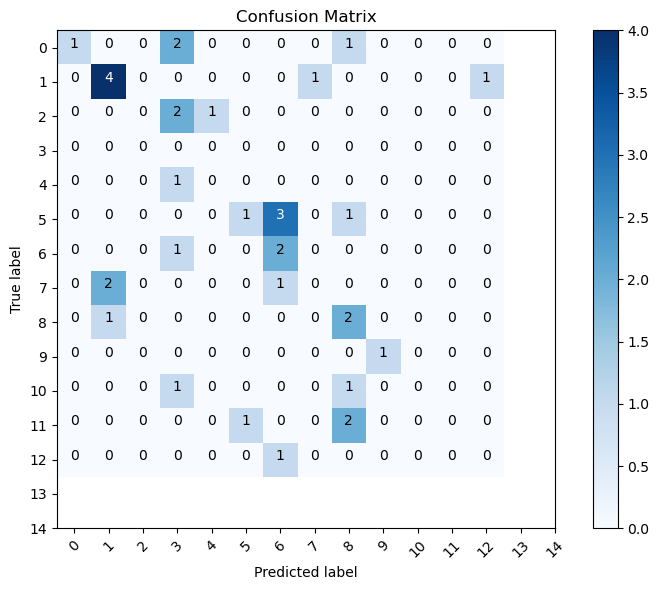

In [53]:
outer_accuracies = []
outer_precisions = []
outer_recalls = []
outer_f1_scores = []
final_svm_model = None


for fold_idx, (X_train_pca_fold, X_test_pca_fold, train_label_fold, test_label_fold) in enumerate(kfold(X_train_pca, train_label, n_splits=20, shuffle=True, random_state=42)):

    print(f"Processing Fold {fold_idx + 1}...")


    best_params = inner_cv_SVM(X_train_pca_fold, train_label_fold, param_grid, n_bootstraps=20)


    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca_fold)


    svm = SVC(C=best_params['C'], kernel=best_params['kernel'], class_weight='balanced')
    svm.fit(X_train_scaled, train_label_fold)


    X_test_scaled = scaler.transform(X_test_pca_fold)
    y_pred = svm.predict(X_test_scaled)

    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')


    if (len(outer_accuracies) == 0):
        final_svm_model = svm
    elif all(test_accuracy > value for value in outer_accuracies):
        final_svm_model = svm

    outer_accuracies.append(test_accuracy)
    outer_precisions.append(precision)
    outer_recalls.append(recall)
    outer_f1_scores.append(f1)

best_outer_accuracy = np.max(outer_accuracies)
std_outer_accuracy = np.std(outer_accuracies)
best_outer_precision = np.max(outer_precisions)
best_outer_recall = np.max(outer_recalls)
best_outer_f1 = np.max(outer_f1_scores)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f} ± {std_outer_accuracy:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

conf_matrix = confusion_matrix(test_label_fold, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_label)))
plt.xticks(tick_marks, np.unique(train_label), rotation=45)
plt.yticks(tick_marks, np.unique(train_label))

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca_fold)

# Creating delta metrics

X_test_pca_scaled = scaler.transform(X_test_pca)
y_pred = final_svm_model.predict(X_test_pca_scaled)

# Calculate metrics
test_accuracy_svm_pca = accuracy_score(test_labels_tensor, y_pred)
test_precision_svm_pca = precision_score(test_labels_tensor, y_pred, average='weighted')
test_recall_svm_pca = recall_score(test_labels_tensor, y_pred, average='weighted')
test_f1_svm_pca = f1_score(test_labels_tensor, y_pred, average='weighted')

# Saving PCA SVM Test Metrics
pca_svm_test_metrics = [test_accuracy_svm_pca, test_precision_svm_pca, test_recall_svm_pca, test_f1_svm_pca]

c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Print test metrics
print("Test Metrics PCA SVM:")
print(f"Accuracy: {pca_svm_test_metrics[0]:.4f}")
print(f"Precision: {pca_svm_test_metrics[1]:.4f}")
print(f"Recall: {pca_svm_test_metrics[2]:.4f}")
print(f"F1 Score: {pca_svm_test_metrics[3]:.4f}")

Test Metrics PCA SVM:
Accuracy: 0.3222
Precision: 0.3408
Recall: 0.3222
F1 Score: 0.2907


## SVM (LDA)

Processing Fold 1...
Processing Fold 2...
Processing Fold 3...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...
Processing Fold 7...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 8...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...
Processing Fold 10...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...
Processing Fold 12...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 14...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 15...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 17...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...
20-Fold Nested CV Accuracy: 0.9143 ± 0.0594
Precision: 0.9500
Recall: 0.9143
F1 Score: 0.9053


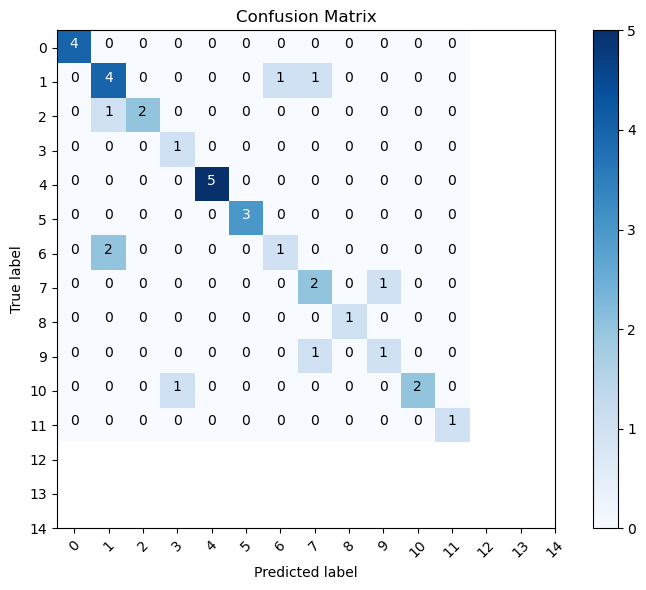

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# Hyperparameter grid for the SVM
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}

def inner_cv_SVM(train_lda, test_lda, param_grid, n_bootstraps=3):
    best_params = None
    best_accuracy = -np.inf

    # Loop over hyperparameter combinations
    for C in param_grid['C']:
        for kernel in param_grid['kernel']:
            avg_accuracy = 0

            for _ in range(n_bootstraps):
                X_train_boot, y_train_boot = resample(train_lda, test_lda, replace=True, n_samples=len(train_lda))

                # Standardize the data
                scaler = StandardScaler()
                X_train_boot_scaled = scaler.fit_transform(X_train_boot)

                # Train SVM
                svm = SVC(C=C, kernel=kernel)
                svm.fit(X_train_boot_scaled, y_train_boot)

                # Out-of-bag prediction
                oob_indices = np.setdiff1d(np.arange(len(train_lda)), np.unique(resample(np.arange(len(train_lda)))))
                X_oob = scaler.transform(train_lda[oob_indices])
                y_oob = test_lda[oob_indices]
                y_pred_oob = svm.predict(X_oob)
                accuracy = accuracy_score(y_oob, y_pred_oob)
                avg_accuracy += accuracy

            avg_accuracy /= n_bootstraps

            # Keep track of the best hyperparameters
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'C': C, 'kernel': kernel}

    return best_params

outer_accuracies_lda = []
outer_precisions_lda = []
outer_recalls_lda = []
outer_f1_scores_lda = []
final_svm_model_lda = None


# K-fold Cross-validation with LDA transformed data
for fold_idx, (X_train_lda_fold, X_test_lda_fold, train_label_fold, test_label_fold) in enumerate(kfold(train_lda, train_label, n_splits=20, shuffle=True, random_state=42)):

    print(f"Processing Fold {fold_idx + 1}...")

    # Inner CV: Bootstrap to find the best hyperparameters
    best_params = inner_cv_SVM(X_train_lda_fold, train_label_fold, param_grid, n_bootstraps=20)

    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_lda_fold)

    # Training model
    svm = SVC(C=best_params['C'], kernel=best_params['kernel'], class_weight='balanced')
    svm.fit(X_train_scaled, train_label_fold)

    # Scaling X_test
    X_test_scaled = scaler.transform(X_test_lda_fold)
    y_pred = svm.predict(X_test_scaled)

    # Calculate metrics
    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')


    if (len(outer_accuracies_lda) == 0):
        final_svm_model_lda = svm
    elif all(test_accuracy > value for value in outer_accuracies_lda):
        final_svm_model_lda = svm



    outer_accuracies_lda.append(test_accuracy)
    outer_precisions_lda.append(precision)
    outer_recalls_lda.append(recall)
    outer_f1_scores_lda.append(f1)

# Calculate mean and standard deviation for metrics
best_outer_accuracy = np.max(outer_accuracies_lda)
std_outer_accuracy = np.std(outer_accuracies_lda)
best_outer_precision = np.max(outer_precisions_lda)
best_outer_recall = np.max(outer_recalls_lda)
best_outer_f1 = np.max(outer_f1_scores_lda)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f} ± {std_outer_accuracy:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

# Display the confusion matrix for the last fold
conf_matrix = confusion_matrix(test_label_fold, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_label)))
plt.xticks(tick_marks, np.unique(train_label), rotation=45)
plt.yticks(tick_marks, np.unique(train_label))

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [57]:
# Running final logistic regression model on test data

scaler = StandardScaler()

# Standardize and evaluate on the outer test set
X_test_scaled_lda_svm = scaler.fit_transform(test_lda)
y_pred_lda_svm = final_svm_model_lda.predict(X_test_scaled_lda_svm)

# Calculate metrics
test_accuracy_svm_lda = accuracy_score(test_labels_tensor, y_pred_lda_svm)
test_precision_svm_lda = precision_score(test_labels_tensor, y_pred_lda_svm, average='weighted')
test_recall_svm_lda = recall_score(test_labels_tensor, y_pred_lda_svm, average='weighted')
test_f1_svm_lda = f1_score(test_labels_tensor, y_pred_lda_svm, average='weighted')

# Saving LDA SVM Test Metrics
lda_svm_test_metrics = [test_accuracy_svm_lda, test_precision_svm_lda, test_recall_svm_lda, test_f1_svm_lda]

In [58]:
# Print test metrics
print("Test Metrics LDA SVM:")
print(f"Accuracy: {lda_svm_test_metrics[0]:.4f}")
print(f"Precision: {lda_svm_test_metrics[1]:.4f}")
print(f"Recall: {lda_svm_test_metrics[2]:.4f}")
print(f"F1 Score: {lda_svm_test_metrics[3]:.4f}")

Test Metrics LDA SVM:
Accuracy: 0.3180
Precision: 0.2983
Recall: 0.3180
F1 Score: 0.3019



## MobNetV2 (PCA)

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
import numpy as np


In [60]:
# Tensor conversion
X_train_pca_MN = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_pca_MN = torch.tensor(X_test_pca, dtype=torch.float32)


In [61]:
# Ensure labels are tensors
if not isinstance(labels_tensor, torch.Tensor):
    labels_tensor = torch.tensor(labels_tensor, dtype=torch.long)

print("train_lda shape:", X_train_pca_MN.shape)
print("labels_tensor shape:", labels_tensor.shape)



train_lda shape: torch.Size([714, 245])
labels_tensor shape: torch.Size([714])


In [62]:
# Dataset preparation
dataset = TensorDataset(X_train_pca_MN, labels_tensor)

# Modified model to handle PCA-transformed 2D data
def create_mobilenet_model_for_pca(num_classes, input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 128),  # Replace Conv2D with a Linear layer for PCA input
        nn.ReLU(),
        nn.Linear(128, num_classes)  # Output layer for classification
    )
    return model


In [63]:
# Training function
def train_mobilenet(model, train_loader_MN, criterion, optimizer, device):
    model.train()
    for images, labels in train_loader_MN:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()



In [64]:
# Evaluation function
def evaluate_model(model, test_loader_MN, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader_MN:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


In [65]:
# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.9, 0.95, 0.99],
    'decay_rate': [0.0, 0.001, 0.01]
}


In [66]:
# Inner cross-validation function
def inner_cv(X_train_pca_MN, y_train_pca, param_grid, n_bootstraps=5):
    best_params = None
    best_accuracy = -np.inf

    # Loop over hyperparameter combinations
    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            for decay_rate in param_grid['decay_rate']:
                avg_accuracy = 0

                for _ in range(n_bootstraps):
                    X_train_boot, y_train_boot = resample(X_train_pca_MN, y_train_pca, replace=True, n_samples=len(X_train_pca_MN))

                    # Create a simple MobileNet model for PCA
                    model = create_mobilenet_model_for_pca(num_classes=len(np.unique(y_train_boot)), input_dim=X_train_boot.shape[1])

                    # Define optimizer with parameters
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=decay_rate)
                    criterion = nn.CrossEntropyLoss()

                    # Train the model
                    model.train()
                    for epoch in range(1):  # Simplified loop for hyperparameter tuning
                        optimizer.zero_grad()
                        outputs = model(X_train_boot.float())
                        loss = criterion(outputs, y_train_boot.clone().detach().long())
                        # loss = criterion(outputs, torch.tensor(y_train_boot).long())
                        loss.backward()
                        optimizer.step()

                    # Evaluate model using OOB samples
                    model.eval()
                    oob_indices = np.setdiff1d(np.arange(len(X_train_pca_MN)), np.unique(resample(np.arange(len(X_train_pca_MN)))))
                    X_oob = X_train_pca_MN[oob_indices]
                    y_oob = y_train_pca[oob_indices]
                    y_pred_oob = model(X_oob.float()).argmax(dim=1).numpy()
                    accuracy = accuracy_score(y_oob, y_pred_oob)
                    avg_accuracy += accuracy

                avg_accuracy /= n_bootstraps

                # Keep track of the best hyperparameters
                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_params = {'learning_rate': learning_rate, 'momentum': momentum, 'decay_rate': decay_rate}

    return best_params



In [84]:
# Outer cross-validation with nested CV
outer_accuracies_pca = []
outer_precisions_pca = []
outer_recalls_pca = []
outer_f1_scores_pca = []
final_MN_model_pca = None

for fold_idx, (X_train_pca_MN_fold, X_test_pca_MN_fold, train_label_fold, test_label_fold) in enumerate(kfold(X_train_pca_MN, labels_tensor, n_splits=20, shuffle=True, random_state=42)):

    print(f"Processing Fold {fold_idx + 1}...")


    # Inner CV: Bootstrap to find the best hyperparameters
    best_params = inner_cv(X_train_pca_MN_fold, train_label_fold, param_grid, n_bootstraps=20)

    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")

    # Create and train the final MobileNet model
    model_mn_pca = create_mobilenet_model_for_pca(num_classes=len(np.unique(train_label_fold)), input_dim=X_train_pca_MN_fold.shape[1])

    # Define optimizer with the best parameters
    optimizer = optim.SGD(model_mn_pca.parameters(), lr=best_params['learning_rate'], momentum=best_params['momentum'], weight_decay=best_params['decay_rate'])
    criterion = nn.CrossEntropyLoss()

    # Train the final model
    model_mn_pca.train()
    for epoch in range(1):  # Simplified loop
        optimizer.zero_grad()
        outputs = model_mn_pca(X_train_pca_MN_fold.float())
        # loss = criterion(outputs, train_label_fold.clone().detach().long())
        loss = criterion(outputs, torch.tensor(train_label_fold).long())
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model_mn_pca.eval()
    X_test_scaled = X_test_pca_MN_fold.float()
    y_pred = model_mn_pca(X_test_scaled).argmax(dim=1).numpy()

    # Calculate metrics
    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')

    if (len(outer_accuracies_pca) == 0):
        final_MN_model_pca = model_mn_pca
    elif all(test_accuracy > value for value in outer_accuracies_pca):
        final_MN_model_pca = model_mn_pca

    outer_accuracies_pca.append(test_accuracy)
    outer_precisions_pca.append(precision)
    outer_recalls_pca.append(recall)
    outer_f1_scores_pca.append(f1)

# Final metrics
best_outer_accuracy = np.max(outer_accuracies_pca)
std_outer_accuracy_pca = np.std(outer_accuracies_pca)
best_outer_precision = np.max(outer_precisions_pca)
best_outer_recall = np.max(outer_recalls_pca)
best_outer_f1 = np.max(outer_f1_scores_pca)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f}± {std_outer_accuracy_pca:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

Processing Fold 1...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 2...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 3...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 7...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 8...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 10...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 12...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 14...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 15...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 17...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...
20-Fold Nested CV Accuracy: 0.2778± 0.0550
Precision: 0.2813
Recall: 0.2778
F1 Score: 0.2111


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\661890270.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy:.4f}± {std_outer_accuracy_pca:.4f}")
print(f"Precision: {best_outer_precision:.4f}")
print(f"Recall: {best_outer_recall:.4f}")
print(f"F1 Score: {best_outer_f1:.4f}")

20-Fold Nested CV Accuracy: 0.2778± 0.0550
Precision: 0.2813
Recall: 0.2778
F1 Score: 0.2111


In [86]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca_fold)

# Creating delta metrics

X_test_pca_scaled = torch.from_numpy(scaler.transform(X_test_pca)).float()
y_pred = model_mn_pca(X_test_pca_scaled).argmax(dim=1).numpy()

# Calculate metrics
test_accuracy_mn_pca = accuracy_score(test_labels_tensor, y_pred)
test_precision_mn_pca = precision_score(test_labels_tensor, y_pred, average='weighted')
test_recall_mn_pca = recall_score(test_labels_tensor, y_pred, average='weighted')
test_f1_mn_pca = f1_score(test_labels_tensor, y_pred, average='weighted')

# Saving PCA SVM Test Metrics
pca_mn_test_metrics = [test_accuracy_mn_pca, test_precision_mn_pca, test_recall_mn_pca, test_f1_mn_pca]

In [87]:
# Print test metrics
print("Test Metrics PCA MN:")
print(f"Accuracy: {pca_mn_test_metrics[0]:.4f}")
print(f"Precision: {pca_mn_test_metrics[1]:.4f}")
print(f"Recall: {pca_mn_test_metrics[2]:.4f}")
print(f"F1 Score: {pca_mn_test_metrics[3]:.4f}")

Test Metrics LDA SVM:
Accuracy: 0.0711
Precision: 0.1139
Recall: 0.0711
F1 Score: 0.0667


## MobNet (LDA)

In [88]:
# Tensor conversion
X_train_lda_MN = torch.tensor(train_lda, dtype=torch.float32)
X_test_lda_MN = torch.tensor(test_lda, dtype=torch.float32)


In [89]:
print(X_train_pca_MN)
print(X_train_lda_MN)

tensor([[ 2.7943e+02,  1.7556e+02, -7.8822e+01,  ..., -1.1063e+00,
         -4.2523e+00,  6.2013e+00],
        [ 2.2807e+02, -5.4350e+01, -1.2173e+01,  ...,  1.4626e+01,
         -1.1398e+01, -4.1185e+00],
        [-6.0471e+00, -1.4979e+02, -1.7214e+01,  ..., -6.0162e-01,
         -2.9296e-01,  1.1704e+00],
        ...,
        [-4.1313e+01,  9.9753e+01,  2.9724e+02,  ...,  2.2672e+00,
         -9.0189e-01,  6.6986e-01],
        [-1.6472e+02, -2.2324e+02, -1.6041e+02,  ..., -6.0226e+00,
         -6.2452e+00,  8.5313e+00],
        [-3.1736e+01, -3.9510e+01, -8.7106e-01,  ..., -6.2471e-01,
          6.6563e+00,  2.2128e+00]])
tensor([[ 0.7113,  0.9744, -0.2076,  ...,  0.8875,  1.0202, -0.4072],
        [-0.0453,  1.2511,  0.3441,  ..., -1.6182,  1.2317, -1.1591],
        [-0.3085, -0.2814, -0.0717,  ..., -0.1944,  0.7080, -0.5846],
        ...,
        [ 1.2772, -1.0607,  2.0671,  ..., -0.3086, -0.3112, -1.7426],
        [-1.6452, -1.3469,  0.1623,  ..., -0.2681, -1.3261, -0.8230],
     

In [90]:
# Ensure labels are tensors
if not isinstance(labels_tensor, torch.Tensor):
    labels_tensor = torch.tensor(labels_tensor, dtype=torch.long)

print("train_lda shape:", X_train_lda_MN.shape)
print("labels_tensor shape:", labels_tensor.shape)



train_lda shape: torch.Size([714, 14])
labels_tensor shape: torch.Size([714])


In [91]:
# Dataset preparation
dataset = TensorDataset(X_train_lda_MN, labels_tensor)

def create_mobilenet_model_for_lda(num_classes, input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)  # Output layer for classification
    )
    return model


In [92]:
# Training function
def train_mobilenet(model, train_loader_MN_lda, criterion, optimizer, device):
    model.train()
    for images, labels in train_loader_MN_lda:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()



In [93]:
# Evaluation function
def evaluate_model(model, test_loader_MN_lda, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader_MN_lda:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


In [94]:
# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.9, 0.95, 0.99],
    'decay_rate': [0.0, 0.001, 0.01]
}


In [95]:
# Inner cross-validation function
def inner_cv(X_train_lda_MN, y_train_lda, param_grid, n_bootstraps=5):
    best_params = None
    best_accuracy = -np.inf

    # Loop over hyperparameter combinations
    for learning_rate in param_grid['learning_rate']:
        for momentum in param_grid['momentum']:
            for decay_rate in param_grid['decay_rate']:
                avg_accuracy = 0

                for _ in range(n_bootstraps):
                    X_train_boot, y_train_boot = resample(X_train_lda_MN, y_train_lda, replace=True, n_samples=len(X_train_lda_MN))

                    model = create_mobilenet_model_for_lda(num_classes=len(np.unique(y_train_boot)), input_dim=X_train_boot.shape[1])

                    # Define optimizer with parameters
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=decay_rate)
                    criterion = nn.CrossEntropyLoss()

                    # Train the model
                    model.train()
                    for epoch in range(1):  # Simplified loop for hyperparameter tuning
                        optimizer.zero_grad()
                        outputs = model(X_train_boot.float())
                        loss = criterion(outputs, y_train_boot.clone().detach().long())
                        loss.backward()
                        optimizer.step()

                    # Evaluate model using OOB samples
                    model.eval()
                    oob_indices = np.setdiff1d(np.arange(len(X_train_lda_MN)), np.unique(resample(np.arange(len(X_train_lda_MN)))))
                    X_oob = X_train_lda_MN[oob_indices]
                    y_oob = y_train_lda[oob_indices]
                    y_pred_oob = model(X_oob.float()).argmax(dim=1).numpy()
                    accuracy = accuracy_score(y_oob, y_pred_oob)
                    avg_accuracy += accuracy

                avg_accuracy /= n_bootstraps

                # Keep track of the best hyperparameters
                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_params = {'learning_rate': learning_rate, 'momentum': momentum, 'decay_rate': decay_rate}

    return best_params



In [96]:
# Outer cross-validation with nested CV
outer_accuracies_lda_mn = []
outer_precisions_lda_mn = []
outer_recalls_lda_mn = []
outer_f1_scores_lda_mn = []
final_MN_model_lda = None



for fold_idx, (X_train_lda_MN_fold, X_test_lda_MN_fold, train_label_fold, test_label_fold) in enumerate(kfold(X_train_lda_MN, labels_tensor, n_splits=20, shuffle=True, random_state=42)):

    print(f"Processing Fold {fold_idx + 1}...")


    # Inner CV: Bootstrap to find the best hyperparameters
    best_params = inner_cv(X_train_lda_MN_fold, train_label_fold, param_grid, n_bootstraps=20)

    if best_params is None:
        raise ValueError("No best parameters found during inner CV. Check the param_grid.")

    # Create and train the final MobileNet model
    model_mn_lda = create_mobilenet_model_for_lda(num_classes=len(np.unique(train_label_fold)), input_dim=X_train_lda_MN_fold.shape[1])

    # Define optimizer with the best parameters
    optimizer = optim.SGD(model_mn_lda.parameters(), lr=best_params['learning_rate'], momentum=best_params['momentum'], weight_decay=best_params['decay_rate'])
    criterion = nn.CrossEntropyLoss()

    # Train the final model
    model_mn_lda.train()
    for epoch in range(1):  # Simplified loop
        optimizer.zero_grad()
        outputs = model_mn_lda(X_train_lda_MN_fold.float())
        loss = criterion(outputs, torch.tensor(train_label_fold).long())
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model_mn_lda.eval()
    X_test_scaled = X_test_lda_MN_fold.float()
    y_pred = model_mn_lda(X_test_scaled).argmax(dim=1).numpy()

    # Calculate metrics
    test_accuracy = accuracy_score(test_label_fold, y_pred)
    precision = precision_score(test_label_fold, y_pred, average='weighted')
    recall = recall_score(test_label_fold, y_pred, average='weighted')
    f1 = f1_score(test_label_fold, y_pred, average='weighted')

    if (len(outer_accuracies_lda) == 0):
        final_MN_model_lda = model_mn_lda
    elif all(test_accuracy > value for value in outer_accuracies_lda):
        final_MN_model_lda = model_mn_lda

    outer_accuracies_lda_mn.append(test_accuracy)
    outer_precisions_lda_mn.append(precision)
    outer_recalls_lda_mn.append(recall)
    outer_f1_scores_lda_mn.append(f1)

# Final metrics
best_outer_accuracy_lda = np.max(outer_accuracies_lda_mn)
std_outer_accuracy_lda = np.std(outer_accuracies_lda_mn)
best_outer_precision_lda = np.max(outer_precisions_lda_mn)
best_outer_recall_lda = np.max(outer_recalls_lda_mn)
best_outer_f1_lda = np.max(outer_f1_scores_lda_mn)

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy_lda:.4f} ± {std_outer_accuracy_lda:.4f}")
print(f"Precision: {best_outer_precision_lda:.4f}")
print(f"Recall: {best_outer_recall_lda:.4f}")
print(f"F1 Score: {best_outer_f1_lda:.4f}")




Processing Fold 1...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 2...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 3...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 4...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 5...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 6...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 7...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 8...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 9...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 10...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 11...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 12...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 13...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 14...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 15...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 16...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 17...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 18...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 19...


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Fold 20...
20-Fold Nested CV Accuracy: 0.2857 ± 0.0682
Precision: 0.4826
Recall: 0.2857
F1 Score: 0.2694


C:\Users\b3nny\AppData\Local\Temp\ipykernel_12584\1328695150.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(train_label_fold).long())
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:

print(f"20-Fold Nested CV Accuracy: {best_outer_accuracy_lda:.4f} ± {std_outer_accuracy_lda:.4f}")
print(f"Precision: {best_outer_precision_lda:.4f}")
print(f"Recall: {best_outer_recall_lda:.4f}")
print(f"F1 Score: {best_outer_f1_lda:.4f}")




20-Fold Nested CV Accuracy: 0.2857 ± 0.0682
Precision: 0.4826
Recall: 0.2857
F1 Score: 0.2694


In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lda_fold)

# Creating delta metrics

X_test_lda_scaled = torch.from_numpy(scaler.transform(test_lda)).float()
y_pred = model_mn_lda(X_test_lda_scaled).argmax(dim=1).numpy()

# Calculate metrics
test_accuracy_mn_lda = accuracy_score(test_labels_tensor, y_pred)
test_precision_mn_lda = precision_score(test_labels_tensor, y_pred, average='weighted')
test_recall_mn_lda = recall_score(test_labels_tensor, y_pred, average='weighted')
test_f1_mn_lda = f1_score(test_labels_tensor, y_pred, average='weighted')

# Saving PCA SVM Test Metrics
lda_mn_test_metrics = [test_accuracy_mn_lda, test_precision_mn_lda, test_recall_mn_lda, test_f1_mn_lda]

c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
# Print test metrics
print("Test Metrics LDA MobileNet:")
print(f"Accuracy: {lda_mn_test_metrics[0]:.4f}")
print(f"Precision: {lda_mn_test_metrics[1]:.4f}")
print(f"Recall: {lda_mn_test_metrics[2]:.4f}")
print(f"F1 Score: {lda_mn_test_metrics[3]:.4f}")

Test Metrics LDA MobileNet:
Accuracy: 0.0460
Precision: 0.0241
Recall: 0.0460
F1 Score: 0.0238


# Robustness Testing

## PCA Robustness Testing

### Logistic Regression

In [103]:
# Creating delta metrics
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(x)


# Standardize and evaluate on the noise test set
X_test_noise_pca_scaled = scaler.fit_transform(X_test_noise_pca)
y_pred_noise = final_logreg_model.predict(X_test_noise_pca_scaled)

# Calculate metrics
noise_accuracy = accuracy_score(test_labels_tensor, y_pred_noise)
noise_precision = precision_score(test_labels_tensor, y_pred_noise, average='weighted')
noise_recall = recall_score(test_labels_tensor, y_pred_noise, average='weighted')
noise_f1 = f1_score(test_labels_tensor, y_pred_noise, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_pca_scaled = scaler.transform(X_test_blur_pca)
y_pred_blur = final_logreg_model.predict(X_test_blur_pca_scaled)

# Calculate metrics
blur_accuracy = accuracy_score(test_labels_tensor, y_pred_blur)
blur_precision = precision_score(test_labels_tensor, y_pred_blur, average='weighted')
blur_recall = recall_score(test_labels_tensor, y_pred_blur, average='weighted')
blur_f1 = f1_score(test_labels_tensor, y_pred_blur, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_pca_scaled = scaler.transform(X_test_noise_blur_pca)
y_pred_noise_blur = final_logreg_model.predict(X_test_noise_blur_pca_scaled)

# Calculate metrics
noise_blur_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_blur)
noise_blur_precision = precision_score(test_labels_tensor, y_pred_noise_blur, average='weighted')
noise_blur_recall = recall_score(test_labels_tensor, y_pred_noise_blur, average='weighted')
noise_blur_f1 = f1_score(test_labels_tensor, y_pred_noise_blur, average='weighted')

In [104]:
# Creating delta variables
delta_noise_accuracy_lr_pca = test_accuracy_lr_pca - noise_accuracy
delta_noise_precision_lr_pca = test_precision_lr_pca - noise_precision
delta_noise_recall_lr_pca = test_recall_lr_pca - noise_recall
delta_noise_f1_lr_pca = test_f1_lr_pca - noise_f1

delta_blur_accuracy_lr_pca = test_accuracy_lr_pca - blur_accuracy
delta_blur_precision_lr_pca = test_precision_lr_pca - blur_precision
delta_blur_recall_lr_pca = test_recall_lr_pca - blur_recall
delta_blur_f1_lr_pca = test_f1_lr_pca - blur_f1

delta_noise_blur_accuracy_lr_pca = test_accuracy_lr_pca - noise_blur_accuracy
delta_noise_blur_precision_lr_pca = test_precision_lr_pca - noise_blur_precision
delta_noise_blur_recall_lr_pca = test_recall_lr_pca - noise_blur_recall
delta_noise_blur_f1_lr_pca = test_f1_lr_pca - noise_blur_f1

# Create a 2D array using a Python list of lists
delta_metrics_lr_pca = [
[delta_noise_accuracy_lr_pca, delta_noise_precision_lr_pca, delta_noise_recall_lr_pca, delta_noise_f1_lr_pca],  # Noise
[delta_blur_accuracy_lr_pca, delta_blur_precision_lr_pca, delta_blur_recall_lr_pca, delta_blur_f1_lr_pca],      # Blur
[delta_noise_blur_accuracy_lr_pca, delta_noise_blur_precision_lr_pca, delta_noise_blur_recall_lr_pca, delta_noise_blur_f1_lr_pca]  # Noise + Blur
]

In [105]:
# Print Noise metrics
print("Logistic Regression - Noise Metrics:")
print(f"Accuracy: {delta_metrics_lr_pca[0][0]:.4f}")
print(f"Precision: {delta_metrics_lr_pca[0][1]:.4f}")
print(f"Recall: {delta_metrics_lr_pca[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_pca[0][3]:.4f}")

# Print Blur metrics
print("\nLogistic Regression - Blur Metrics:")
print(f"Accuracy: {delta_metrics_lr_pca[1][0]:.4f}")
print(f"Precision: {delta_metrics_lr_pca[1][1]:.4f}")
print(f"Recall: {delta_metrics_lr_pca[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_pca[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nLogistic Regression - Noise + Blur Metrics:")
print(f"Accuracy: {delta_metrics_lr_pca[2][0]:.4f}")
print(f"Precision: {delta_metrics_lr_pca[2][1]:.4f}")
print(f"Recall: {delta_metrics_lr_pca[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_pca[2][3]:.4f}")


Logistic Regression - Noise Metrics:
Accuracy: -0.0418
Precision: -0.0042
Recall: -0.0418
F1 Score: -0.0329

Logistic Regression - Blur Metrics:
Accuracy: -0.0460
Precision: -0.0000
Recall: -0.0460
F1 Score: -0.0329

Logistic Regression - Noise + Blur Metrics:
Accuracy: -0.0084
Precision: 0.0497
Recall: -0.0084
F1 Score: 0.0113


### SVM

In [106]:
# Creating delta metrics

X_test_noise_pca_scaled = scaler.transform(X_test_noise_pca)
y_pred_noise = final_svm_model.predict(X_test_noise_pca_scaled)

# Calculate metrics
noise_accuracy = accuracy_score(test_labels_tensor, y_pred_noise)
noise_precision = precision_score(test_labels_tensor, y_pred_noise, average='weighted')
noise_recall = recall_score(test_labels_tensor, y_pred_noise, average='weighted')
noise_f1 = f1_score(test_labels_tensor, y_pred_noise, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_pca_scaled = scaler.transform(X_test_blur_pca)
y_pred_blur = final_svm_model.predict(X_test_blur_pca_scaled)

# Calculate metrics
blur_accuracy = accuracy_score(test_labels_tensor, y_pred_blur)
blur_precision = precision_score(test_labels_tensor, y_pred_blur, average='weighted')
blur_recall = recall_score(test_labels_tensor, y_pred_blur, average='weighted')
blur_f1 = f1_score(test_labels_tensor, y_pred_blur, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_pca_scaled = scaler.transform(X_test_noise_blur_pca)
y_pred_noise_blur = final_svm_model.predict(X_test_noise_blur_pca_scaled)

# Calculate metrics
noise_blur_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_blur)
noise_blur_precision = precision_score(test_labels_tensor, y_pred_noise_blur, average='weighted')
noise_blur_recall = recall_score(test_labels_tensor, y_pred_noise_blur, average='weighted')
noise_blur_f1 = f1_score(test_labels_tensor, y_pred_noise_blur, average='weighted')

c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
# Creating delta variables
delta_noise_accuracy_svm_pca = test_accuracy_svm_pca - noise_accuracy
delta_noise_precision_svm_pca = test_precision_svm_pca - noise_precision
delta_noise_recall_svm_pca = test_recall_svm_pca - noise_recall
delta_noise_f1_svm_pca = test_f1_svm_pca - noise_f1

delta_blur_accuracy_svm_pca = test_accuracy_svm_pca - blur_accuracy
delta_blur_precision_svm_pca = test_precision_svm_pca - blur_precision
delta_blur_recall_svm_pca = test_recall_svm_pca - blur_recall
delta_blur_f1_svm_pca = test_f1_svm_pca - blur_f1

delta_noise_blur_accuracy_svm_pca = test_accuracy_svm_pca - noise_blur_accuracy
delta_noise_blur_precision_svm_pca = test_precision_svm_pca - noise_blur_precision
delta_noise_blur_recall_svm_pca = test_recall_svm_pca - noise_blur_recall
delta_noise_blur_f1_svm_pca = test_f1_svm_pca - noise_blur_f1

# Create a 2D array using a Python list of lists
delta_metrics_svm_pca = [
[delta_noise_accuracy_svm_pca, delta_noise_precision_svm_pca, delta_noise_recall_svm_pca, delta_noise_f1_svm_pca],  # Noise
[delta_blur_accuracy_svm_pca, delta_blur_precision_svm_pca, delta_blur_recall_svm_pca, delta_blur_f1_svm_pca],      # Blur
[delta_noise_blur_accuracy_svm_pca, delta_noise_blur_precision_svm_pca, delta_noise_blur_recall_svm_pca, delta_noise_blur_f1_svm_pca]  # Noise + Blur
]


In [108]:
# Print Noise metrics
print("Noise Metrics:")
print(f"Accuracy: {delta_metrics_svm_pca[0][0]:.4f}")
print(f"Precision: {delta_metrics_svm_pca[0][1]:.4f}")
print(f"Recall: {delta_metrics_svm_pca[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_pca[0][3]:.4f}")

# Print Blur metrics
print("\nBlur Metrics:")
print(f"Accuracy: {delta_metrics_svm_pca[1][0]:.4f}")
print(f"Precision: {delta_metrics_svm_pca[1][1]:.4f}")
print(f"Recall: {delta_metrics_svm_pca[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_pca[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nNoise + Blur Metrics:")
print(f"Accuracy: {delta_metrics_svm_pca[2][0]:.4f}")
print(f"Precision: {delta_metrics_svm_pca[2][1]:.4f}")
print(f"Recall: {delta_metrics_svm_pca[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_pca[2][3]:.4f}")


Noise Metrics:
Accuracy: -0.0335
Precision: -0.0773
Recall: -0.0335
F1 Score: -0.0583

Blur Metrics:
Accuracy: -0.0377
Precision: -0.0477
Recall: -0.0377
F1 Score: -0.0627

Noise + Blur Metrics:
Accuracy: 0.0000
Precision: 0.0005
Recall: 0.0000
F1 Score: -0.0165


### MobNet

In [109]:
# Creating delta metrics
scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train_pca)
X_test_noise_pca_scaled = torch.from_numpy(scaler.transform(X_test_noise_pca)).float()
y_pred_noise_mn_pca = model_mn_pca(X_test_noise_pca_scaled).argmax(dim=1).numpy()

# Calculate metrics
noise_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_mn_pca)
noise_precision = precision_score(test_labels_tensor, y_pred_noise_mn_pca, average='weighted')
noise_recall = recall_score(test_labels_tensor, y_pred_noise_mn_pca, average='weighted')
noise_f1 = f1_score(test_labels_tensor, y_pred_noise_mn_pca, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_pca_scaled_mn = torch.from_numpy(scaler.transform(X_test_blur_pca)).float()
y_pred_blur_mn_pca = model_mn_pca(X_test_blur_pca_scaled_mn).argmax(dim=1).numpy()

# Calculate metrics
blur_accuracy = accuracy_score(test_labels_tensor, y_pred_blur_mn_pca)
blur_precision = precision_score(test_labels_tensor, y_pred_blur_mn_pca, average='weighted')
blur_recall = recall_score(test_labels_tensor, y_pred_blur_mn_pca, average='weighted')
blur_f1 = f1_score(test_labels_tensor, y_pred_blur_mn_pca, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_pca_scaled_mn = torch.from_numpy(scaler.transform(X_test_noise_blur_pca)).float()
y_pred_noise_blur_mn_pca = model_mn_pca(X_test_noise_blur_pca_scaled_mn).argmax(dim=1).numpy()

# Calculate metrics
noise_blur_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_blur_mn_pca)
noise_blur_precision = precision_score(test_labels_tensor, y_pred_noise_blur_mn_pca, average='weighted')
noise_blur_recall = recall_score(test_labels_tensor, y_pred_noise_blur_mn_pca, average='weighted')
noise_blur_f1 = f1_score(test_labels_tensor, y_pred_noise_blur_mn_pca, average='weighted')

c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
# Creating delta variables
delta_noise_accuracy_mn_pca = test_accuracy_mn_pca - noise_accuracy
delta_noise_precision_mn_pca = test_precision_mn_pca - noise_precision
delta_noise_recall_mn_pca = test_recall_mn_pca - noise_recall
delta_noise_f1_mn_pca = test_f1_mn_pca - noise_f1

delta_blur_accuracy_mn_pca = test_accuracy_mn_pca - blur_accuracy
delta_blur_precision_mn_pca = test_precision_mn_pca - blur_precision
delta_blur_recall_mn_pca = test_recall_mn_pca - blur_recall
delta_blur_f1_mn_pca = test_f1_mn_pca - blur_f1

delta_noise_blur_accuracy_mn_pca = test_accuracy_mn_pca - noise_blur_accuracy
delta_noise_blur_precision_mn_pca = test_precision_mn_pca - noise_blur_precision
delta_noise_blur_recall_mn_pca = test_recall_mn_pca - noise_blur_recall
delta_noise_blur_f1_mn_pca = test_f1_mn_pca - noise_blur_f1

# Create a 2D array using a Python list of lists
delta_metrics_mn_pca = [
[delta_noise_accuracy_mn_pca, delta_noise_precision_mn_pca, delta_noise_recall_mn_pca, delta_noise_f1_mn_pca],  # Noise
[delta_blur_accuracy_mn_pca, delta_blur_precision_mn_pca, delta_blur_recall_mn_pca, delta_blur_f1_mn_pca],      # Blur
[delta_noise_blur_accuracy_mn_pca, delta_noise_blur_precision_mn_pca, delta_noise_blur_recall_mn_pca, delta_noise_blur_f1_mn_pca]  # Noise + Blur
]


In [111]:
# Print Noise metrics
print("Noise Metrics:")
print(f"Accuracy: {delta_metrics_mn_pca[0][0]:.4f}")
print(f"Precision: {delta_metrics_mn_pca[0][1]:.4f}")
print(f"Recall: {delta_metrics_mn_pca[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_pca[0][3]:.4f}")

# Print Blur metrics
print("\nBlur Metrics:")
print(f"Accuracy: {delta_metrics_mn_pca[1][0]:.4f}")
print(f"Precision: {delta_metrics_mn_pca[1][1]:.4f}")
print(f"Recall: {delta_metrics_mn_pca[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_pca[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nNoise + Blur Metrics:")
print(f"Accuracy: {delta_metrics_mn_pca[2][0]:.4f}")
print(f"Precision: {delta_metrics_mn_pca[2][1]:.4f}")
print(f"Recall: {delta_metrics_mn_pca[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_pca[2][3]:.4f}")

Noise Metrics:
Accuracy: -0.0126
Precision: -0.0121
Recall: -0.0126
F1 Score: -0.0109

Blur Metrics:
Accuracy: -0.0209
Precision: -0.0233
Recall: -0.0209
F1 Score: -0.0142

Noise + Blur Metrics:
Accuracy: -0.0209
Precision: 0.0487
Recall: -0.0209
F1 Score: -0.0023


## LDA Robustness Testing

### Logistic Regression

In [112]:
# Creating delta metrics

# Standardize and evaluate on the noise test set
X_test_noise_lda_scaled_lr = scaler.fit_transform(X_test_noise_lda)
y_pred_noise_lda_lr = final_logreg_model_lda.predict(X_test_noise_lda_scaled_lr)

# Calculate metrics
noise_accuracy_lda_lr = accuracy_score(test_labels_tensor_lda, y_pred_noise_lda_lr)
noise_precision_lda_lr = precision_score(test_labels_tensor_lda, y_pred_noise_lda_lr, average='weighted')
noise_recall_lda_lr = recall_score(test_labels_tensor_lda, y_pred_noise_lda_lr, average='weighted')
noise_f1_lda_lr = f1_score(test_labels_tensor_lda, y_pred_noise_lda_lr, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_lda_scaled_lda = scaler.transform(X_test_blur_lda)
y_pred_blur_lda_lr = final_logreg_model_lda.predict(X_test_blur_lda_scaled_lda)

# Calculate metrics
blur_accuracy_lda_lr = accuracy_score(test_labels_tensor_lda, y_pred_blur_lda_lr)
blur_precision_lda_lr  = precision_score(test_labels_tensor_lda, y_pred_blur_lda_lr, average='weighted')
blur_recall_lda_lr  = recall_score(test_labels_tensor_lda, y_pred_blur_lda_lr, average='weighted')
blur_f1_lda_lr  = f1_score(test_labels_tensor_lda, y_pred_blur_lda_lr, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_lda_scaled_lr = scaler.transform(X_test_noise_blur_lda)
y_pred_noise_blur_lda_lr = final_logreg_model_lda.predict(X_test_noise_blur_lda_scaled_lr)

# Calculate metrics
noise_blur_accuracy_lda_lr  = accuracy_score(test_labels_tensor_lda, y_pred_noise_blur_lda_lr)
noise_blur_precision_lda_lr  = precision_score(test_labels_tensor_lda, y_pred_noise_blur_lda_lr, average='weighted')
noise_blur_recall_lda_lr  = recall_score(test_labels_tensor_lda, y_pred_noise_blur_lda_lr, average='weighted')
noise_blur_f1_lda_lr  = f1_score(test_labels_tensor_lda, y_pred_noise_blur_lda_lr, average='weighted')

In [113]:
# Creating delta variables
delta_noise_accuracy_lda_lr = test_accuracy_lr_lda - noise_accuracy_lda_lr
delta_noise_precision_lda_lr = test_precision_lr_lda - noise_precision_lda_lr
delta_noise_recall_lda_lr = test_recall_lr_lda - noise_recall_lda_lr
delta_noise_f1_lda_lr = test_f1_lr_lda - noise_f1_lda_lr

delta_blur_accuracy_lda_lr = test_accuracy_lr_lda - blur_accuracy_lda_lr
delta_blur_precision_lda_lr = test_precision_lr_lda - blur_precision_lda_lr
delta_blur_recall_lda_lr = test_recall_lr_lda - blur_recall_lda_lr
delta_blur_f1_lda_lr = test_f1_lr_lda - blur_f1_lda_lr

delta_noise_blur_accuracy_lda_lr = test_accuracy_lr_lda - noise_blur_accuracy_lda_lr
delta_noise_blur_precision_lda_lr = test_precision_lr_lda - noise_blur_precision_lda_lr
delta_noise_blur_recall_lda_lr = test_recall_lr_lda - noise_blur_recall_lda_lr
delta_noise_blur_f1_lda_lr = test_f1_lr_lda - noise_blur_f1_lda_lr

# Create a 2D array using a Python list of lists
delta_metrics_lr_lda = [
[delta_noise_accuracy_lda_lr, delta_noise_precision_lda_lr, delta_noise_recall_lda_lr, delta_noise_f1_lda_lr],  # Noise
[delta_blur_accuracy_lda_lr, delta_blur_precision_lda_lr, delta_blur_recall_lda_lr, delta_blur_f1_lda_lr],      # Blur
[delta_noise_blur_accuracy_lda_lr, delta_noise_blur_precision_lda_lr, delta_noise_blur_recall_lda_lr, delta_noise_blur_f1_lda_lr]  # Noise + Blur
]

In [114]:
# Print Noise metrics
print("Noise Metrics LR:")
print(f"Accuracy: {delta_metrics_lr_lda[0][0]:.4f}")
print(f"Precision: {delta_metrics_lr_lda[0][1]:.4f}")
print(f"Recall: {delta_metrics_lr_lda[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_lda[0][3]:.4f}")

# Print Blur metrics
print("\nBlur Metrics LR:")
print(f"Accuracy: {delta_metrics_lr_lda[1][0]:.4f}")
print(f"Precision: {delta_metrics_lr_lda[1][1]:.4f}")
print(f"Recall: {delta_metrics_lr_lda[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_lda[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nNoise + Blur Metrics LR:")
print(f"Accuracy: {delta_metrics_lr_lda[2][0]:.4f}")
print(f"Precision: {delta_metrics_lr_lda[2][1]:.4f}")
print(f"Recall: {delta_metrics_lr_lda[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_lr_lda[2][3]:.4f}")


Noise Metrics LR:
Accuracy: 0.0209
Precision: -0.0032
Recall: 0.0209
F1 Score: 0.0084

Blur Metrics LR:
Accuracy: 0.0293
Precision: 0.0066
Recall: 0.0293
F1 Score: 0.0164

Noise + Blur Metrics LR:
Accuracy: 0.0293
Precision: 0.0367
Recall: 0.0293
F1 Score: 0.0343


### SVM

In [115]:
# Creating delta metrics

# Standardize and evaluate on the noise test set
X_test_noise_lda_scaled = scaler.transform(X_test_noise_lda)
y_pred_noise_lda = final_svm_model_lda.predict(X_test_noise_lda_scaled)

# Calculate metrics
noise_accuracy_lda = accuracy_score(test_labels_tensor_lda, y_pred_noise_lda)
noise_precision_lda = precision_score(test_labels_tensor_lda, y_pred_noise_lda, average='weighted')
noise_recall_lda = recall_score(test_labels_tensor_lda, y_pred_noise_lda, average='weighted')
noise_f1_lda = f1_score(test_labels_tensor_lda, y_pred_noise_lda, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_lda_scaled = scaler.transform(X_test_blur_lda)
y_pred_blur_lda = final_svm_model_lda.predict(X_test_blur_lda_scaled)

# Calculate metrics
blur_accuracy_lda = accuracy_score(test_labels_tensor_lda, y_pred_blur_lda)
blur_precision_lda  = precision_score(test_labels_tensor_lda, y_pred_blur_lda, average='weighted')
blur_recall_lda  = recall_score(test_labels_tensor_lda, y_pred_blur_lda, average='weighted')
blur_f1_lda  = f1_score(test_labels_tensor_lda, y_pred_blur_lda, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_lda_scaled = scaler.transform(X_test_noise_blur_lda)
y_pred_noise_blur_lda = final_svm_model_lda.predict(X_test_noise_blur_lda_scaled)

# Calculate metrics
noise_blur_accuracy_lda  = accuracy_score(test_labels_tensor_lda, y_pred_noise_blur_lda)
noise_blur_precision_lda  = precision_score(test_labels_tensor_lda, y_pred_noise_blur_lda, average='weighted')
noise_blur_recall_lda  = recall_score(test_labels_tensor_lda, y_pred_noise_blur_lda, average='weighted')
noise_blur_f1_lda  = f1_score(test_labels_tensor_lda, y_pred_noise_blur_lda, average='weighted')

In [116]:
# Creating delta variables
delta_noise_accuracy_svm_lda = test_accuracy_svm_lda - noise_accuracy_lda
delta_noise_precision_svm_lda = test_precision_svm_lda - noise_precision_lda
delta_noise_recall_svm_lda = test_recall_svm_lda - noise_recall_lda
delta_noise_f1_svm_lda = test_f1_svm_lda - noise_f1_lda

delta_blur_accuracy_svm_lda = test_accuracy_svm_lda - blur_accuracy_lda
delta_blur_precision_svm_lda = test_precision_svm_lda - blur_precision_lda
delta_blur_recall_svm_lda = test_recall_svm_lda - blur_recall_lda
delta_blur_f1_svm_lda = test_f1_svm_lda - blur_f1_lda

delta_noise_blur_accuracy_svm_lda = test_accuracy_svm_lda - noise_blur_accuracy_lda
delta_noise_blur_precision_svm_lda = test_precision_svm_lda - noise_blur_precision_lda
delta_noise_blur_recall_svm_lda = test_recall_svm_lda - noise_blur_recall_lda
delta_noise_blur_f1_svm_lda = test_f1_svm_lda - noise_blur_f1_lda

# Create a 2D array using a Python list of lists
delta_metrics_svm_lda = [
[delta_noise_accuracy_svm_lda, delta_noise_precision_svm_lda, delta_noise_recall_svm_lda, delta_noise_f1_svm_lda],  # Noise
[delta_blur_accuracy_svm_lda, delta_blur_precision_svm_lda, delta_blur_recall_svm_lda, delta_blur_f1_svm_lda],      # Blur
[delta_noise_blur_accuracy_svm_lda, delta_noise_blur_precision_svm_lda, delta_noise_blur_recall_svm_lda, delta_noise_blur_f1_svm_lda]  # Noise + Blur
]

In [117]:
# Print Noise metrics
print("Noise Metrics SVM:")
print(f"Accuracy: {delta_metrics_svm_lda[0][0]:.4f}")
print(f"Precision: {delta_metrics_svm_lda[0][1]:.4f}")
print(f"Recall: {delta_metrics_svm_lda[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_lda[0][3]:.4f}")

# Print Blur metrics
print("\nBlur Metrics SVM:")
print(f"Accuracy: {delta_metrics_svm_lda[1][0]:.4f}")
print(f"Precision: {delta_metrics_svm_lda[1][1]:.4f}")
print(f"Recall: {delta_metrics_svm_lda[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_lda[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nNoise + Blur Metrics SVM:")
print(f"Accuracy: {delta_metrics_svm_lda[2][0]:.4f}")
print(f"Precision: {delta_metrics_svm_lda[2][1]:.4f}")
print(f"Recall: {delta_metrics_svm_lda[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_svm_lda[2][3]:.4f}")


Noise Metrics SVM:
Accuracy: -0.0502
Precision: -0.0725
Recall: -0.0502
F1 Score: -0.0609

Blur Metrics SVM:
Accuracy: -0.0335
Precision: -0.0327
Recall: -0.0335
F1 Score: -0.0342

Noise + Blur Metrics SVM:
Accuracy: -0.0418
Precision: -0.0457
Recall: -0.0418
F1 Score: -0.0378


### MobNet

In [118]:
# Creating delta metrics
scaler = StandardScaler()
X_train_scaled = scaler.fit(X_test_noise_lda)
X_test_noise_lda_scaled = torch.from_numpy(scaler.transform(X_test_noise_lda)).float()
y_pred_noise_mn_lda = model_mn_lda(X_test_noise_lda_scaled).argmax(dim=1).numpy()

# Calculate metrics
noise_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_mn_lda)
noise_precision = precision_score(test_labels_tensor, y_pred_noise_mn_lda, average='weighted')
noise_recall = recall_score(test_labels_tensor, y_pred_noise_mn_lda, average='weighted')
noise_f1 = f1_score(test_labels_tensor, y_pred_noise_mn_lda, average='weighted')

# Standardize and evaluate on the blur test set
X_test_blur_lda_scaled = torch.from_numpy(scaler.transform(X_test_blur_lda)).float()
y_pred_blur_mn_lda = model_mn_lda(X_test_blur_lda_scaled).argmax(dim=1).numpy()

# Calculate metrics
blur_accuracy = accuracy_score(test_labels_tensor, y_pred_blur_mn_lda)
blur_precision = precision_score(test_labels_tensor, y_pred_blur_mn_lda, average='weighted')
blur_recall = recall_score(test_labels_tensor, y_pred_blur_mn_lda, average='weighted')
blur_f1 = f1_score(test_labels_tensor, y_pred_blur_mn_lda, average='weighted')

# Standardize and evaluate on the noise and blur test set
X_test_noise_blur_lda_scaled = torch.from_numpy(scaler.transform(X_test_noise_blur_lda)).float()
y_pred_noise_blur_mn_lda = model_mn_lda(X_test_noise_blur_lda_scaled).argmax(dim=1).numpy()

# Calculate metrics
noise_blur_accuracy = accuracy_score(test_labels_tensor, y_pred_noise_blur_mn_lda)
noise_blur_precision = precision_score(test_labels_tensor, y_pred_noise_blur_mn_lda, average='weighted')
noise_blur_recall = recall_score(test_labels_tensor, y_pred_noise_blur_mn_lda, average='weighted')
noise_blur_f1 = f1_score(test_labels_tensor, y_pred_noise_blur_mn_lda, average='weighted')

c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\b3nny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
# Creating delta variables
delta_noise_accuracy_mn_lda = test_accuracy_mn_lda - noise_accuracy
delta_noise_precision_mn_lda = test_precision_mn_lda - noise_precision
delta_noise_recall_mn_lda = test_recall_mn_lda - noise_recall
delta_noise_f1_mn_lda = test_f1_mn_lda - noise_f1

delta_blur_accuracy_mn_lda = test_accuracy_mn_lda - blur_accuracy
delta_blur_precision_mn_lda = test_precision_mn_lda - blur_precision
delta_blur_recall_mn_lda = test_recall_mn_lda - blur_recall
delta_blur_f1_mn_lda = test_f1_mn_lda - blur_f1

delta_noise_blur_accuracy_mn_lda = test_accuracy_mn_lda - noise_blur_accuracy
delta_noise_blur_precision_mn_lda = test_precision_mn_lda - noise_blur_precision
delta_noise_blur_recall_mn_lda = test_recall_mn_lda - noise_blur_recall
delta_noise_blur_f1_mn_lda = test_f1_mn_lda - noise_blur_f1

# Create a 2D array using a Python list of lists
delta_metrics_mn_lda = [
[delta_noise_accuracy_mn_lda, delta_noise_precision_mn_lda, delta_noise_recall_mn_lda, delta_noise_f1_mn_lda],  # Noise
[delta_blur_accuracy_mn_lda, delta_blur_precision_mn_lda, delta_blur_recall_mn_lda, delta_blur_f1_mn_lda],      # Blur
[delta_noise_blur_accuracy_mn_lda, delta_noise_blur_precision_mn_lda, delta_noise_blur_recall_mn_lda, delta_noise_blur_f1_mn_lda]  # Noise + Blur
]

In [120]:
# Print Noise metrics
print("Noise Metrics:")
print(f"Accuracy: {delta_metrics_mn_lda[0][0]:.4f}")
print(f"Precision: {delta_metrics_mn_lda[0][1]:.4f}")
print(f"Recall: {delta_metrics_mn_lda[0][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_lda[0][3]:.4f}")

# Print Blur metrics
print("\nBlur Metrics:")
print(f"Accuracy: {delta_metrics_mn_lda[1][0]:.4f}")
print(f"Precision: {delta_metrics_mn_lda[1][1]:.4f}")
print(f"Recall: {delta_metrics_mn_lda[1][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_lda[1][3]:.4f}")

# Print Noise + Blur metrics
print("\nNoise + Blur Metrics:")
print(f"Accuracy: {delta_metrics_mn_lda[2][0]:.4f}")
print(f"Precision: {delta_metrics_mn_lda[2][1]:.4f}")
print(f"Recall: {delta_metrics_mn_lda[2][2]:.4f}")
print(f"F1 Score: {delta_metrics_mn_lda[2][3]:.4f}")

Noise Metrics:
Accuracy: 0.0000
Precision: 0.0061
Recall: 0.0000
F1 Score: 0.0031

Blur Metrics:
Accuracy: -0.0126
Precision: -0.0138
Recall: -0.0126
F1 Score: -0.0085

Noise + Blur Metrics:
Accuracy: -0.0084
Precision: 0.0016
Recall: -0.0084
F1 Score: 0.0018


# Visualisation

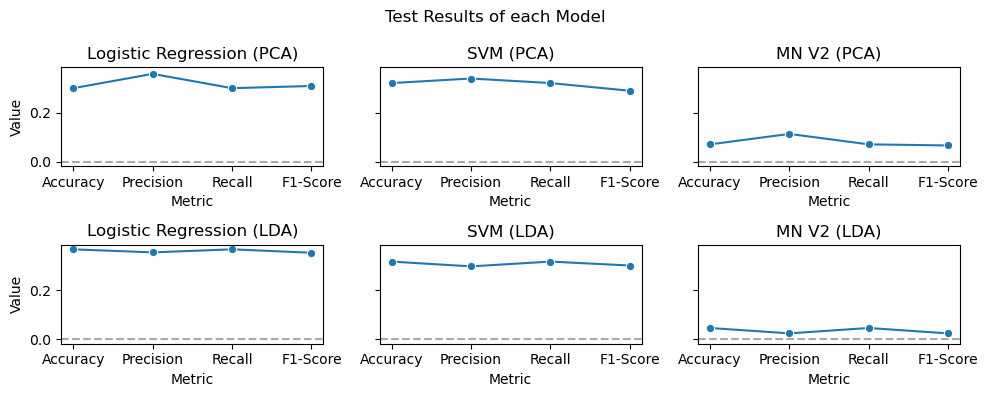

In [168]:
# Data for Logistic Regression
data_lr_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': pca_lr_test_metrics
}
df_lr_pca = pd.DataFrame(data_lr_pca)

# Data for SVM
data_svm_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': pca_svm_test_metrics
}
df_svm_pca = pd.DataFrame(data_svm_pca)

# Data for MN
data_mn_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': pca_mn_test_metrics
}
df_mn_pca = pd.DataFrame(data_mn_pca)

# Data for Logistic Regression
data_lr_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': lda_lr_test_metrics
}
df_lr_lda = pd.DataFrame(data_lr_lda)

# Data for SVM
data_svm_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': lda_svm_test_metrics
}
df_svm_lda = pd.DataFrame(data_svm_lda)

# Data for MN
data_mn_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': lda_mn_test_metrics
}
df_mn_lda = pd.DataFrame(data_mn_lda)

# Create subplots with shared y-axis
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=True)
fig.suptitle('Test Results of each Model')

# PCA

# Plot Logistic Regression
sns.lineplot(x='Metric', y='Value', data=df_lr_pca, marker='o', ax=axes[0][0])
axes[0][0].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][0].set_title('Logistic Regression (PCA)')
axes[0][0].set_xlabel('Metric')
axes[0][0].set_ylabel('Value')

# Plot SVM
sns.lineplot(x='Metric', y='Value', data=df_svm_pca, marker='o', ax=axes[0][1])
axes[0][1].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][1].set_title('SVM (PCA)')
axes[0][1].set_xlabel('Metric')

# Plot MN
sns.lineplot(x='Metric', y='Value', data=df_mn_pca, marker='o', ax=axes[0][2])
axes[0][2].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][2].set_title('MN V2 (PCA)')
axes[0][2].set_xlabel('Metric')

# LDA

# Plot Logistic Regression
sns.lineplot(x='Metric', y='Value', data=df_lr_lda, marker='o', ax=axes[1][0])
axes[1][0].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][0].set_title('Logistic Regression (LDA)')
axes[1][0].set_xlabel('Metric')
axes[1][0].set_ylabel('Value')

# Plot SVM
sns.lineplot(x='Metric', y='Value', data=df_svm_lda, marker='o', ax=axes[1][1])
axes[1][1].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][1].set_title('SVM (LDA)')
axes[1][1].set_xlabel('Metric')

# Plot SVM
sns.lineplot(x='Metric', y='Value', data=df_mn_lda, marker='o', ax=axes[1][2])
axes[1][2].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][2].set_title('MN V2 (LDA)')
axes[1][2].set_xlabel('Metric')

plt.tight_layout()
plt.show()

In [145]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

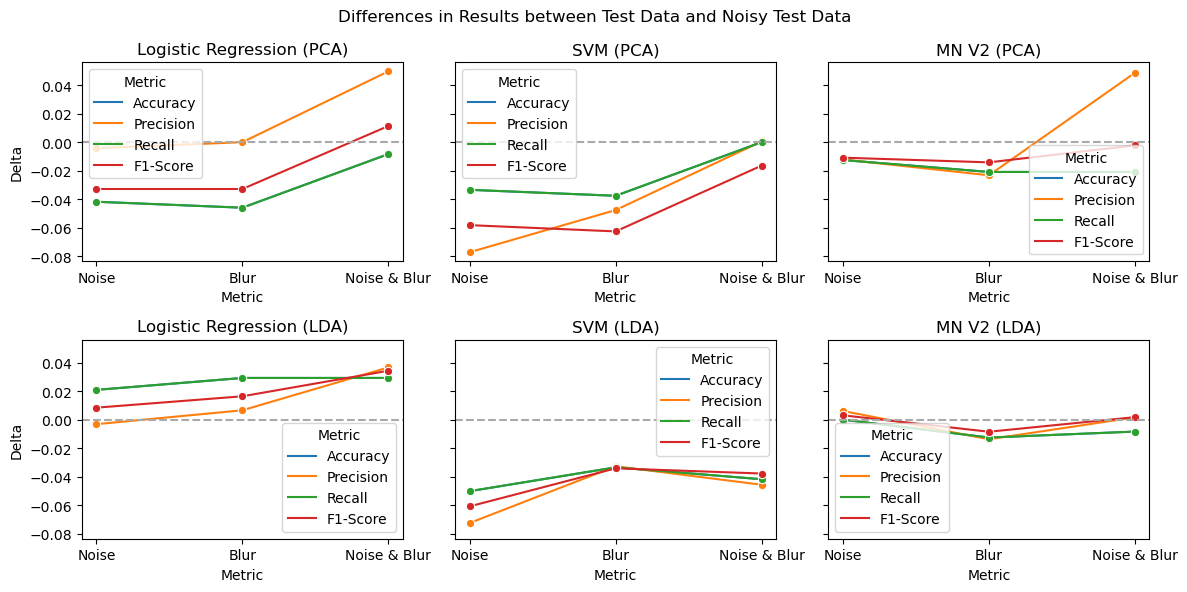

In [170]:
# Data for Logistic Regression
# data_lr_pca = {
#     'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
#     'Noise_Delta': delta_metrics_lr_pca[0],
#     'Blur_Delta': delta_metrics_lr_pca[1],
#     'Noise_Blur_Delta': delta_metrics_lr_pca[2]
# }
# df_lr_pca = pd.DataFrame(data_lr_pca)

data_lr_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_lr_pca)
}

df_lr_pca = pd.DataFrame(data_lr_pca)

# Data for SVM
data_svm_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_svm_pca)
}
df_svm_pca = pd.DataFrame(data_svm_pca)

# Data for MN
data_mn_pca = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_mn_pca)
}
df_mn_pca = pd.DataFrame(data_mn_pca)

# Data for Logistic Regression
data_lr_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_lr_lda)
}
df_lr_lda = pd.DataFrame(data_lr_lda)

# Data for SVM
data_svm_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_svm_lda)
}
df_svm_lda = pd.DataFrame(data_svm_lda)

# Data for MN
data_mn_lda = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'] * 3,
    'Condition': ['Noise'] * 4 + ['Blur'] * 4 + ['Noise & Blur'] * 4,
    'Delta': flatten_comprehension(delta_metrics_mn_lda)
}
df_mn_lda = pd.DataFrame(data_mn_lda)

# Create subplots with shared y-axis
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
fig.suptitle('Differences in Results between Test Data and Noisy Test Data')

# PCA

# Plot Logistic Regression
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_lr_pca, marker='o', ax=axes[0][0])
axes[0][0].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][0].set_title('Logistic Regression (PCA)')
axes[0][0].set_xlabel('Metric')
axes[0][0].set_ylabel('Delta')
axes[0][0].legend(title='Metric')

# Plot SVM
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_svm_pca, marker='o', ax=axes[0][1])
axes[0][1].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][1].set_title('SVM (PCA)')
axes[0][1].set_xlabel('Metric')
# axes[0][1].legend(title='Metric')

# Plot MN
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_mn_pca, marker='o', ax=axes[0][2])
axes[0][2].axhline(y=0, color='darkgrey', linestyle='--')
axes[0][2].set_title('MN V2 (PCA)')
axes[0][2].set_xlabel('Metric')
# axes[0][2].legend(title='Metric')

# LDA

# Plot Logistic Regression
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_lr_lda, marker='o', ax=axes[1][0])
axes[1][0].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][0].set_title('Logistic Regression (LDA)')
axes[1][0].set_xlabel('Metric')
axes[1][0].set_ylabel('Delta')
# axes[1][0].legend(title='Metric')

# Plot SVM
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_svm_lda, marker='o', ax=axes[1][1])
axes[1][1].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][1].set_title('SVM (LDA)')
axes[1][1].set_xlabel('Metric')
# axes[1][1].legend(title='Metric')

# Plot MN
sns.lineplot(x='Condition', y='Delta', hue='Metric', data=df_mn_lda, marker='o', ax=axes[1][2])
axes[1][2].axhline(y=0, color='darkgrey', linestyle='--')
axes[1][2].set_title('MN V2 (LDA)')
axes[1][2].set_xlabel('Metric')
# axes[1][2].legend(title='Metric')

plt.tight_layout()
plt.show()